# Predição de Séries Temporais utilizando Regressão Linear

## Exercício 1

No presente exercício será construído um preditor linear, onde com base em K amostras passadas será previsto o valor 
no instante de tempo imediatamente posterior. Assim, o vetor x(n) de entradas será constituido por 
x(n) = [x(n-1) ... x(n-K)]. Assim para cada valor de x(n) será calculado um valor y(n) correspondente a estimação.

Para este exercício será utilizado o conjunto de dados correspondente a temperatura mínima da cidade de Melbourne nos 
anos de 1981 até 1990. 

In [174]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from numpy.random import uniform
import matplotlib.pyplot as plt

In [175]:
#Lendo os dados
filename = 'daily-minimum-temperatures.csv'
dataset = pd.read_csv(filename)

In [176]:
#Analisando os dados
dataset.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [177]:
#Não há ausência de dados
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date    3650 non-null object
Temp    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.1+ KB


O conjunto de dados de temperatura está disposto em 3650 linhas e 2 colunas, onde cada linha representa uma amostra de temperatura. As colunas correspondem às datas e as temperaturas mínimas. Como também pode ser visto, o conjunto de dados não contém ausência de nenhum valor.

## Preparação dos dados

Antes da realização do treinamento, o conjunto de dados foi separado em duas partes, o conjunto de treinamento e o conjunto de teste. O conjunto de treinamento é formado pelas temperaturas correspondentes aos anos de 1981 até 1989. Assim, o conjunto de teste é formado pelas temperaturas referentes ao ano de 1990.

In [178]:
#O último ano será utilizado como conjunto de teste.
x_training_date = dataset.iloc[0:(len(dataset)-365), 0]
n_training = np.arange(0, len(x_training_date))
y_training = dataset.iloc[0:(len(dataset)-365), 1].to_numpy()

x_test = dataset.iloc[(len(dataset)-365):, 0]
n_test = np.arange((len(dataset)-365), len(dataset))
y_test = dataset.iloc[(len(dataset)-365):, 1].to_numpy()

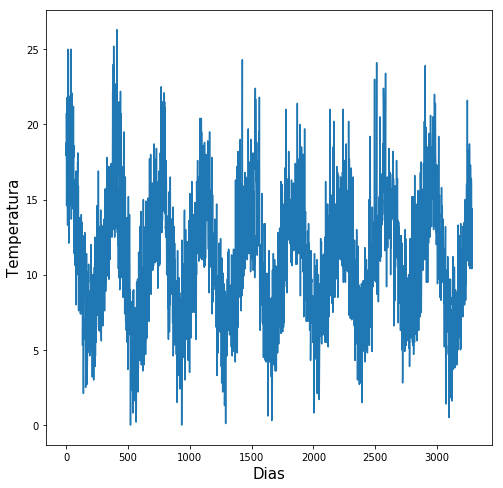

In [179]:
#Exibindo os dados de treinamento

fig = plt.figure(figsize=(8, 8))
plt.plot(n_training, y_training)
plt.rc('axes', labelsize=15)
plt.ylabel('Temperatura')
plt.xlabel('Dias')

plt.show()

## Treinamento e Seleção de Parâmetros

In [180]:
#Construção do algoritmo de regressão linear utilizando a equação normal
#Esta função retorna o vetor de pesos W que está relacionado com o conjunto de dados X e Y.

def linear_regression_normal_equation(x, y, lambda_param):
    x_trans = x.T  
    k = x.shape[1]
    I_line = np.eye(k)
    I_line[0, 0] = 0
    
    w = (inv(x_trans.dot(x)+lambda_param*I_line).dot(x_trans)).dot(y)
    return w

#Esta função recebe um conjunto de temperaturas e retorna o conjunto de vetores de 
#predição de acordo com a regra x(n) = [x(n-1) ... x(n-k)].
#É importante notar que o conjunto será regresentado por n = (k-1) até N, onde N representa
#o número de amostras de temperatura

def create_predictor_set(y, k):
    N = y.shape[0]
    
    X = np.zeros((N-k, k))
    Y = np.zeros(N-k)
    
    for i in range(N-k):
        for j in range(k):
            X[i, j] = y[i+k-j-1]
            Y[i] = y[i+k]

    return X, Y

#A função create_k_fold_set recebe os dados de treinamento x e y e faz a separação dos dados em treinamento
#e validação. A função também recebe o número de treinamentos a serem realizados (k) bem como a localização
#do conjunto de validação (i)

def create_k_fold_set(x, y, k, i):
    dataset_length = len(x)
    validation_size = np.floor(dataset_length/k)
    train_indices = np.arange(0, dataset_length)    
    
    if (i == k-1): 
        validation_indices = i*validation_size + np.arange(0, validation_size + np.remainder(dataset_length, k))
    else:
        validation_indices = i*validation_size + np.arange(0, validation_size)
    
    validation_indices = validation_indices.astype(int)
    training_indices = np.delete(train_indices, validation_indices)
    
    x_validation = x[validation_indices] 
    y_validation = y[validation_indices]
    
    x_training = x[training_indices]
    y_training = y[training_indices]
    
    return x_validation, y_validation, x_training, y_training

def calculate_SSD(X_validation, W, Y_validation):
    #Criação do modelo
    N = X_validation.shape[0]

    Y_hat = np.dot(X_validation, W)
    
    e2 = np.square(Y_hat - Y_validation)
    
    ssd = (1/N)*np.sum(e2)
    
    return ssd, Y_hat

Para o treinamento foi avaliado o algoritmo de regressão linear. A sua implementação foi realizada utilizando a equação normal, assim, a minimização da soma dos mínimos quadrados (SSD) foi utilizada como métrica. Não foi realizada a normalização nem a regularização dos dados.

Para a seleção da quantidades de amostras passadas (K) foi utilizado o esquema de validação cruzada utilizando a abordagem k-fold. Nesse caso foi utilizado um valor de k igual a 4, correspondendo assim a 4 divisões do conjunto de treinamento.

Para avaliar qual o melhor valor de K foi utilizado a raiz da soma dos quadrados (RMSE).

In [181]:
#Exercício 1

k = 4 #Número de partições na validação cruzada k-fold
ssd_val = np.zeros(k)

ssd_K_val = np.zeros(30)

for K in range(1, 31):
    X_predictor, Y_predictor = create_predictor_set(y_training, K)

    for i in range(k):
        X_validation, Y_validation, X_training, Y_training = create_k_fold_set(X_predictor, Y_predictor, k, i)        
        
        X_training = np.concatenate((np.ones((X_training.shape[0], 1)), X_training), axis=1)
        X_validation = np.concatenate((np.ones((X_validation.shape[0], 1)), X_validation), axis=1)

        w = linear_regression_normal_equation(X_training, Y_training, 0)

        ssd_val[i], Y_val = calculate_SSD(X_validation, w, Y_validation)
    
    ssd_K_val[K-1] = (1/k)*np.sum(ssd_val)
    
rms_K_val = np.sqrt(ssd_K_val)

No processo de validação cruzada, pôde ser visto que o menor valor de K (2.4291) corresponde a 18 amostras passadas. 

18
2.429100806409831


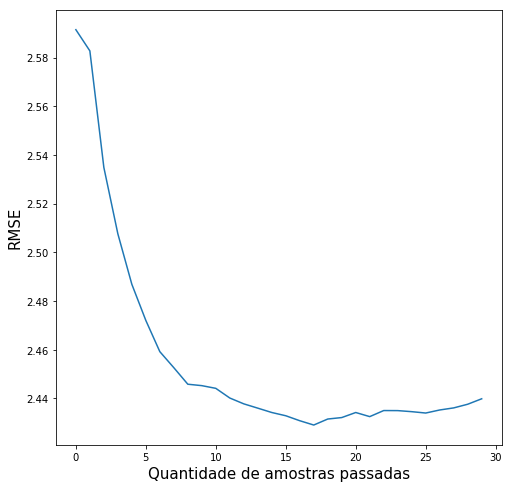

In [182]:
fig = plt.figure(figsize=(8, 8))
plt.plot(rms_K_val)
plt.xlabel("Quantidade de amostras passadas")
plt.ylabel("RMSE")
K_min = np.argmin(rms_K_val) + 1
print(K_min)
print(rms_K_val[K_min-1])
plt.show()
fig.savefig("Desempenho_RMSE_Linear.png")

Por fim, o modelo foi avaliado no conjunto de testes e a comparação pode ser vista no gráfico abaixo. O erro RMS avaliado no conjunto de testes foi de 4.95.

4.954023254911128


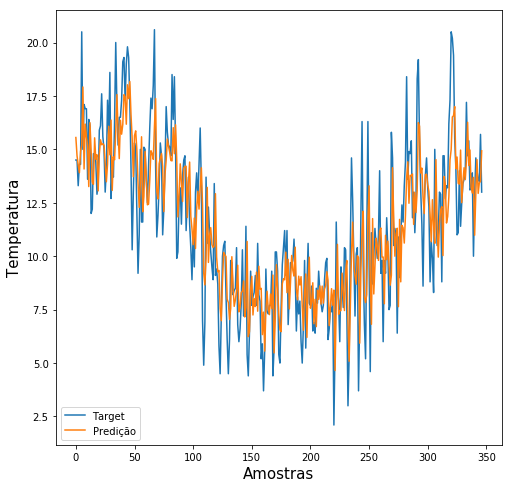

In [183]:
#Avaliando o modelo no conjunto de teste.
x_test_predictor, y_test_predictor = create_predictor_set(y_test, K_min)
x_test_predictor = np.concatenate((np.ones((x_test_predictor.shape[0], 1)), x_test_predictor), axis=1)

w_min = linear_regression_normal_equation(x_test_predictor, y_test_predictor, 0)

ssd, y_predict = calculate_SSD(x_test_predictor, w_min, y_test_predictor)
print(ssd)

fig = plt.figure(figsize=(8, 8))

plt.plot(y_test_predictor)
plt.plot(y_predict)
plt.xlabel("Amostras")
plt.ylabel("Temperatura")
plt.legend(("Target", "Predição"))
fig.savefig("Predicao_linear.png")

## Exercício 2

In [184]:
def normalize_data(X_data):
    N_features = X_data.shape[1]
    N_samples = X_data.shape[0]
    X = np.zeros((N_samples, N_features))
    
    for i in range(N_features):
        xi_max = np.max(X_data[:, i])
        
        X[:, i] = X_data[:, i]/xi_max
    
    return X

#def unnormalize_data(X_data, Y_data):
    

In [185]:
kf = 4 #Número de partições na validação cruzada k-fold

ssd_val = np.zeros(kf)
ssd_K_val = np.zeros((100, 100))

X_predictor2, Y_predictor2 = create_predictor_set(y_training, 5)

#Normalizing the data
X_predictor2 = normalize_data(X_predictor2)

N = X_predictor2.shape[0]

for T in range(1, 101):
    X_training2 = np.zeros((N, T))
    for k in range(1, T+1):
        w_k = uniform(0, 0.45, 5)
        
        X_training2[:, k-1] = np.tanh(np.dot(X_predictor2, w_k))
    index=0    
    for l in np.arange(0, 1, 0.01):
        for i in range(kf):
            X_validation, Y_validation, X_training, Y_training = create_k_fold_set(X_training2, Y_predictor2, kf, i)

            X_training = np.concatenate((np.ones((X_training.shape[0], 1)), X_training), axis=1)
            X_validation = np.concatenate((np.ones((X_validation.shape[0], 1)), X_validation), axis=1)

            w = linear_regression_normal_equation(X_training, Y_training, l)

            ssd_val[i], Y_val = calculate_SSD(X_validation, w, Y_validation)
        
        ssd_K_val[T-1, index] = (1/kf)*np.sum(ssd_val)
        index+=1
l_min = np.argmin(ssd_K_val, axis=1)
            
rms_K_val = np.sqrt(ssd_K_val)           

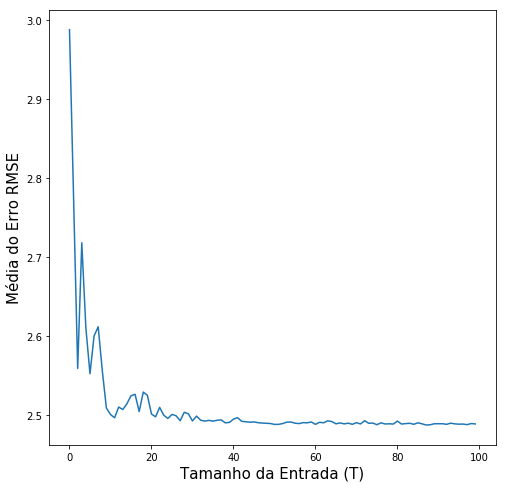

In [186]:
rms_K_val_T_mean = np.mean(rms_K_val, axis=1)

fig = plt.figure(figsize=(8, 8))
plt.plot(rms_K_val_T_mean)
plt.xlabel("Tamanho da Entrada (T)")
plt.ylabel("Média do Erro RMSE")
fig.savefig("Media_Erro_RMSE.png")

[[11  0]]
2.4685717936584783
5.375327909619952


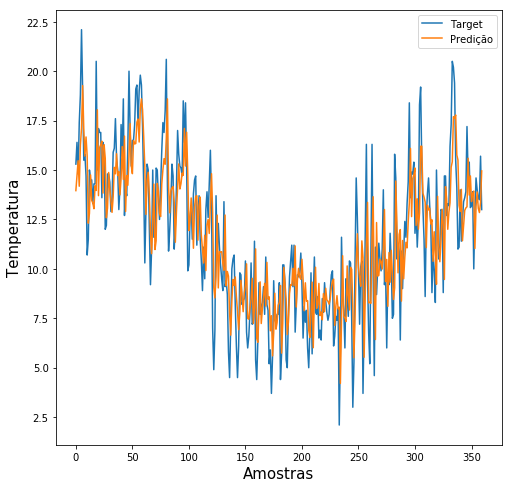

In [199]:
print(np.argwhere(rms_K_val == np.min(rms_K_val)))
print(np.min(rms_K_val))

#Avaliando o modelo no conjunto de teste.
x_test_predictor, y_test_predictor = create_predictor_set(y_test, 5)
X_predictor2 = normalize_data(x_test_predictor)

X_training2 = np.zeros((x_test_predictor.shape[0], 12))
for k in range(1, 12):
    w_k = uniform(0, 1, 5)    
    X_training2[:, k-1] = np.tanh(np.dot(X_predictor2, w_k))
        
x_test_predictor = np.concatenate((np.ones((x_test_predictor.shape[0], 1)), x_test_predictor), axis=1)

w_min = linear_regression_normal_equation(x_test_predictor, y_test_predictor, 0)

ssd, y_predict = calculate_SSD(x_test_predictor, w_min, y_test_predictor)
print(ssd)
fig = plt.figure(figsize=(8, 8))

plt.plot(y_test_predictor)
plt.plot(y_predict)
plt.xlabel("Amostras")
plt.ylabel("Temperatura")
plt.legend(("Target", "Predição"))

fig.savefig("Predicao_Nao_linear.png")

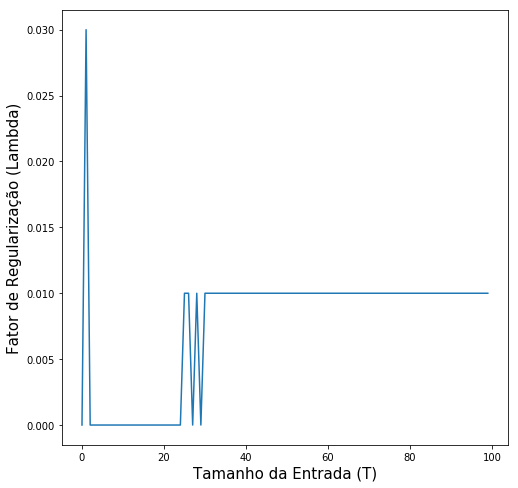

In [198]:

fig = plt.figure(figsize=(8, 8))
plt.plot(l_min/100)
plt.xlabel("Tamanho da Entrada (T)")
plt.ylabel("Fator de Regularização (Lambda)")
fig.savefig("Lambda_T.png")